In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import QuantileTransformer
import copy

from torch_functions import *
from MVCS import *

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  

## Import the data

In [2]:


def split_and_preprocess(X, Y, splits=[0.7, 0.1, 0.1, 0.1]):
    """
    Sépare les données selon les proportions spécifiées et applique une normalisation par quantiles.
    
    Args:
        X (numpy.ndarray): Features of shape (n_samples, d).
        Y (numpy.ndarray): Outputs of shape (n_samples, k).
        splits (list): Proportions of the dataset to use for training, validation, calibration and testing.
        
    Returns:
        dict: Un dictionnaire contenant les ensembles de données transformés.
    """
    if not np.isclose(sum(splits), 1.0, atol=1e-10):
        raise ValueError("Proportions need to sum to 1.0.")
    
    n_samples = X.shape[0]
    split_sizes = [int(n_samples * p ) for p in splits]
    split_sizes[-1] = n_samples - sum(split_sizes[:-1])  
        
    indices = np.random.permutation(n_samples)
    X, Y = X[indices], Y[indices]
    
    # Découper les ensembles selon les tailles définies
    start = 0
    subsets = {}
    subset_names = ["X_train", "X_stop", "X_calibration", "X_test"] if len(splits) == 4 else ["X_train", "X_calibration", "X_test"]
    
    for i, name in enumerate(subset_names):
        end = start + split_sizes[i]
        subsets[name] = X[start:end]
        subsets[name.replace("X_", "Y_")] = Y[start:end]
        start = end
    
    x_transformer = QuantileTransformer(output_distribution='normal')
    subsets["X_train"] = x_transformer.fit_transform(subsets["X_train"])
    for name in subset_names[1:]:  
        subsets[name] = x_transformer.transform(subsets[name])

    y_transformer = QuantileTransformer(output_distribution='normal')
    subsets["Y_train"] = y_transformer.fit_transform(subsets["Y_train"])
    for name in [n.replace("X_", "Y_") for n in subset_names[1:]]:
        subsets[name] = y_transformer.transform(subsets[name])

    
    return subsets


load_path = "../data/processed_data/house.npz"
data = np.load(load_path)
X, Y = data['X'], data['Y']

subsets = split_and_preprocess(X, Y, splits=[0.7, 0.1, 0.1, 0.1])
x_train, y_train, x_calibration, y_calibration, x_test, y_test, x_stop, y_stop = subsets["X_train"], subsets["Y_train"], subsets["X_calibration"], subsets["Y_calibration"], subsets["X_test"], subsets["Y_test"], subsets["X_stop"], subsets["Y_stop"]

dtype = torch.float64

x_train_tensor = torch.tensor(x_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train, dtype=dtype)
x_stop_tensor = torch.tensor(x_stop, dtype=dtype)
y_stop_tensor = torch.tensor(y_stop, dtype=dtype)
x_calibration_tensor = torch.tensor(x_calibration, dtype=dtype)
y_calibration_tensor = torch.tensor(y_calibration, dtype=dtype)
x_test_tensor = torch.tensor(x_test, dtype=dtype)
y_test_tensor = torch.tensor(y_test, dtype=dtype)


print("X_train shape:", x_train.shape, "Y_train shape:", y_train.shape)
print("X_cal shape:", x_calibration.shape, "Y_cal shape:", y_calibration.shape)
print("X_test shape:", x_test.shape, "Y_test shape:", y_test.shape)
print("X_stop shape:", x_stop.shape, "Y_stop shape:", y_stop.shape)

d = x_train.shape[1]
k = y_train.shape[1]

alpha = 0.1

X_train shape: (15129, 17) Y_train shape: (15129, 2)
X_cal shape: (2161, 17) Y_cal shape: (2161, 2)
X_test shape: (2162, 17) Y_test shape: (2162, 2)
X_stop shape: (2161, 17) Y_stop shape: (2161, 2)


## Declare the variables and model

In [3]:
class Network(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim = 100, n_hidden_layers = 1):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_channels, hidden_dim)
        self.tab_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_hidden_layers)])
        self.fc3 = nn.Linear(hidden_dim, output_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for hidden in self.tab_hidden:
            x = F.relu(hidden(x))
        x = self.fc3(x)
        return x

    def fit(self, train_loader, epochs, verbose=False):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(epochs):
            for i, (X_batch, Y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                output = self(X_batch)
                loss = F.mse_loss(output, Y_batch)
                loss.backward()
                optimizer.step()
            if verbose:
                print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')
    
    def fit(self, train_loader, stop_loader, epochs, lr = 0.001, verbose=False):
        best_weights = None
        best_loss = float('inf')
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses = []
        stop_losses = []
        for epoch in range(epochs):
            for i, (X_batch, Y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                output = self(X_batch)
                loss = F.mse_loss(output, Y_batch)
                loss.backward()
                optimizer.step()
            train_loss = self.eval(train_loader)
            stop_loss = self.eval(stop_loader)
            train_losses.append(train_loss)
            stop_losses.append(stop_loss)
            if stop_loss < best_loss:
                best_loss = stop_loss
                best_weights = copy.deepcopy(self.state_dict())
            if verbose:
                print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}, Stop Loss: {stop_loss}')
   
        self.load_state_dict(best_weights)
        return train_losses, stop_losses

    def eval(self, loader):
        with torch.no_grad():
            loss = 0
            for i, (X_batch, Y_batch) in enumerate(loader):
                output = self(X_batch)
                loss += F.mse_loss(output, Y_batch)
            return loss / len(loader)

class MatrixPredictor(nn.Module):
    def __init__(self, input_dim, output_rows, output_cols, hidden_dim = 100, n_hidden_layers = 0):
        super(MatrixPredictor, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.n_hidden_layers = n_hidden_layers
        if n_hidden_layers > 0:
            self.tab_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_hidden_layers)])
        self.fc2 = nn.Linear(hidden_dim, output_rows * output_cols)
        self.output_rows = output_rows
        self.output_cols = output_cols

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        if self.n_hidden_layers > 0:
            for hidden in self.tab_hidden:
                x = F.relu(hidden(x))
        output = self.fc2(x)
        return output.view(-1, self.output_rows, self.output_cols)
    
model_center = Network(d, k, hidden_dim = 256, n_hidden_layers = 3).to(dtype)
model_matrix = MatrixPredictor(d, k, k, hidden_dim = 256, n_hidden_layers = 3).to(dtype)

model_center_init = copy.deepcopy(model_center)
model_matrix_init = copy.deepcopy(model_matrix)

## Usage of Ellipsoid Predictor

### A. Training

In [4]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= 100, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= 100, shuffle=True)


# First, train the center model only with the strategy you want 
train_losses, stop_losses = model_center.fit(trainloader, stoploader, epochs=500, lr=0.0001)


trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= 100, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= 100, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= 100, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= 100, shuffle=True)

MVCS_predictor = MVCSPredictor(model_center, model_matrix)

MVCS_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = 200,             # The total number of epochs
                        num_epochs_mat_only = 100,    # The first 100 epochs are used to train the matrix model only
                        lr_model = 0.0001,            # The learning rate for the center model
                        lr_q = 0.01,                  # The learning rate for q (the q-norm)
                        lr_matrix_model = 0.004,      # The learning rate for the matrix model
                        use_lr_scheduler = True,      # Use a learning rate scheduler (with cosine annealing)
                        verbose = 1,                  # The verbosity level (0 : No verbose; 1: Print the loss 10 times or 2: Print the loss at each epoch)
                        stop_on_best = True,          # Stop the training when the best model is found on a stop set (that is different from the calibration set and test set)
                        loss_strategy = "log_volume", # The loss strategy to use (either the log volume or the exact volume)
                        use_epsilon = False,          # Add an epsilon to the loss to avoid numerical issues, usally not needed
                        )


Epoch 0: Loss = -0.13181383504360866 - Stop Loss = 0.7696495057745381 - Best Stop Loss = 0.7696495057745381
Epoch 20: Loss = -0.24903029321986736 - Stop Loss = 0.5931333530068343 - Best Stop Loss = 0.5479457769893159
Epoch 40: Loss = -0.24233710463052205 - Stop Loss = 0.7090132577710975 - Best Stop Loss = 0.5479457769893159
Epoch 60: Loss = -0.29946631384292033 - Stop Loss = 0.6736414123259777 - Best Stop Loss = 0.5479457769893159
Epoch 80: Loss = -0.2883087903973731 - Stop Loss = 0.6180183811484738 - Best Stop Loss = 0.5479457769893159
Epoch 100: Loss = 0.07013306058131263 - Stop Loss = 0.6681374605648998 - Best Stop Loss = 0.5479457769893159
Epoch 120: Loss = 0.06151382225002067 - Stop Loss = 0.6467294861871977 - Best Stop Loss = 0.5479457769893159
Epoch 140: Loss = -0.1591573734331675 - Stop Loss = 0.5956298864784131 - Best Stop Loss = 0.5425672782539266
Epoch 160: Loss = -0.29951125558491043 - Stop Loss = 0.5551764883528563 - Best Stop Loss = 0.5425672782539266
Epoch 180: Loss = -0

### B. Conformalizing

In [5]:
MVCS_predictor.conformalize(calibrationloader, alpha = alpha)

### C. Testing

In [6]:
# For a given test set :
ellipsoid_coverage = MVCS_predictor.get_coverage(testloader)
ellipsoid_volume   = MVCS_predictor.get_averaged_volume(testloader)

print("The coverage on the test loader is {:.2f} and the average volume is {:.2f}\n\n".format(ellipsoid_coverage, ellipsoid_volume))

# Or for some points 
x_to_test = x_test_tensor[:10]
y_to_test = y_test_tensor[:10]

in_ellipsoid = MVCS_predictor.is_inside(x_to_test, y_to_test)
tab_volumes = MVCS_predictor.get_volumes(x_test=x_to_test)

print("Are the points in the ellipsoid ?  : ", in_ellipsoid)
print("The volumes of the set for each points are : ", tab_volumes) # The volumes of the set for each points

The coverage on the test loader is 0.90 and the average volume is 1.76


Are the points in the ellipsoid ?  :  tensor([True, True, True, True, True, True, True, True, True, True])
The volumes of the set for each points are :  tensor([2.0960, 1.9563, 1.4769, 3.0403, 2.2019, 3.1162, 2.1602, 1.5917, 2.8154,
        1.5720], dtype=torch.float64)


### D. Get Lambdas and plot (if k=2) the sets

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_77020/2389900473.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 7)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_77020/2389900473.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_test[i, 0], y_test[i, 1],  c=color_map(i), alpha=0.5)


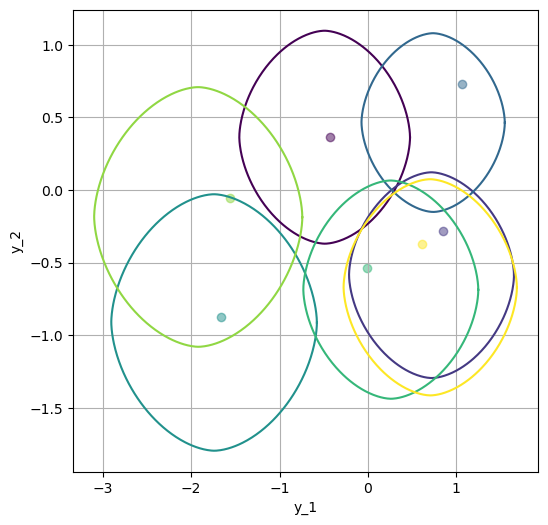

In [7]:
def add_ellipse(ax, center, Lambda, q, conformal_value, color='blue', linestyle = '-', label='Conformal Ellipse'):
    """
       plot -> {y, \| \Lambda (u - center) \|_q^q \leq conformal_value}  }
       conformal_value = radius ** q
    """

    # Generate a set of points on a unit circle
    theta = np.linspace(0, 2 * np.pi, 500)
    unit_circle = np.vstack((np.cos(theta), np.sin(theta)))
    
    # Scale the unit circle points to match the conformal value under the q-norm
    scaling = conformal_value * np.power(np.sum(np.abs(unit_circle) ** q, axis=0), -1/q)
    scaled_points = unit_circle * scaling
    
    # Apply the linear transformation Lambda
    transformed_points = np.linalg.inv(Lambda) @ scaled_points
    
    # Translate the ellipse to the center
    ellipse_points = transformed_points + np.reshape(center, (2, 1))
    
    # Add the ellipse to the existing plot
    ax.plot(ellipse_points[0, :], ellipse_points[1, :], label=label, c=color, linestyle=linestyle)
   #  ax.scatter(*center, color='red', label='Center')
    
    
    return ax

f_x_test = MVCS_predictor.center_model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()

Lambdas_test = MVCS_predictor.get_Lambdas(x_test_tensor)
Lambdas_test_np = Lambdas_test.detach().numpy()

q_val = MVCS_predictor.q.item()

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 7)
for i in range(7):    
    ax.scatter(y_test[i, 0], y_test[i, 1],  c=color_map(i), alpha=0.5)
    ax = add_ellipse(ax,  f_x_test_np[i], Lambdas_test_np[i], q_val, MVCS_predictor.nu_conformal.item(), color = color_map(i), label=None)    

ax.grid(True)
    
ax.set_xlabel('y_1')
ax.set_ylabel('y_2')

plt.show()
plt.close()